# Task 1: Data Prepping

## 1.1 - Loading the data 

- **_[TO DO]_**: Load the climate data from LAB1 (5 Danish cities between 1980-2018), and store them into Pandas data frames.
- **_[TO DO]_**: Have a quick overview of the downloaded dataset and make sure to understand the variables contained in the dataframe. Pay particular attention to the DateTime. 

**[HINT]:** In this case, the index of the dataframe is not an integer (i.e., 0, 1, 2,...) as seen in the previous lab. But we have a multiple index (MultiIndex) [pandas.DataFrame.xs](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.xs.html). Check the website to see how select the data of the desidered city.
    


In [2]:
###########################
# Tasks:
#   Load climate data from LAB1 
#   Quick overview of the dataset:
#       - understand the variables in the dataframe
#       - check the Data time for two cities 
###########################

### TO DO
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_pickle('weather-data/weather-denmark.pkl')
df.dtypes
df
#########

Temp  Pressure  WindSpeed  WindDir
City     DateTime                                               
Aalborg  1980-03-01 00:00:00   5.0    1008.1       11.3    290.0
         1980-03-01 00:20:00   4.0       NaN        9.2    270.0
         1980-03-01 00:50:00   4.0       NaN        9.2    280.0
         1980-03-01 01:20:00   4.0       NaN        9.2    280.0
         1980-03-01 01:50:00   4.0       NaN        8.7    270.0
...                            ...       ...        ...      ...
Roskilde 2018-03-01 22:20:00  -5.0       NaN        5.1     70.0
         2018-03-01 22:50:00  -5.0       NaN        4.1     70.0
         2018-03-01 23:00:00  -5.3    1018.6        4.1     60.0
         2018-03-01 23:20:00  -5.0       NaN        3.6     60.0
         2018-03-01 23:50:00  -5.0       NaN        3.6     60.0

[2918150 rows x 4 columns]

## 1.2 - Data interpolation

Many time series analyses assume observations over uniform time intervals. In the real world, incoming data often does not arrive in this way. As a result, one common prerequisite for Time Series analysis is to take an initially raw input and transform it into discrete intervals, or to resample an input at one frequency into an input of a different frequency.

For instance, we plot the temperature data for the cities of Aalborg and Aarhus in the day 1st March 2018 from 00am to 12pm. We can notice that the temperature data for the two cities is not always recorded at the same time.

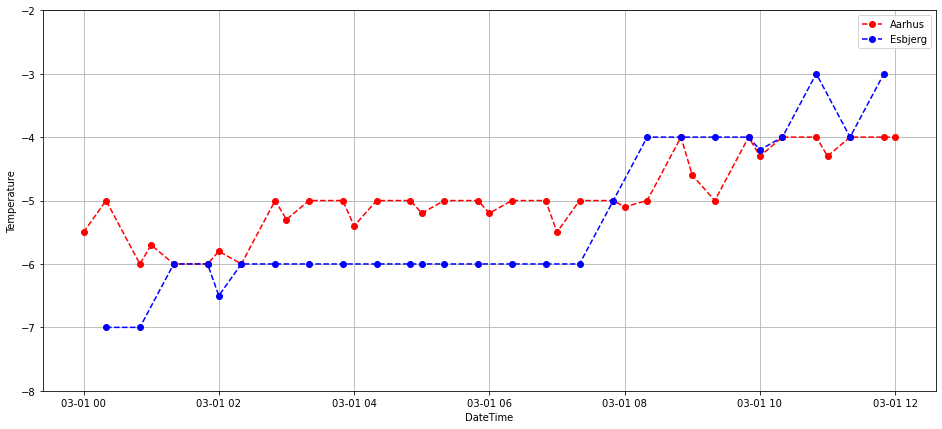

In [3]:
# List of the Danish cities in this data-set.
cities = ['Aalborg', 'Aarhus', 'Esbjerg', 'Odense', 'Roskilde']

city_1 = df.xs(cities[1])
city_2 = df.xs(cities[2])

plt.figure(figsize=(16, 7))
plt.plot(city_1.loc['2018-03-01 00:00:00':'2018-03-01 12:00:00', 'Temp'],
         label='Aarhus', linestyle='--', marker='o',  c='r')

plt.plot(city_2.loc['2018-03-01 00:00:00':'2018-03-01 12:00:00', 'Temp'],
         label='Esbjerg', linestyle='--', marker='o',  c='b')

plt.xlabel('DateTime')
plt.ylabel('Temperature')

plt.ylim([-8, -2])
plt.grid()
plt.legend()
plt.show()


As just observed, this dataset contains data recorded with an irregular interval across cities. Therefore, before continuing with the data analysis, we will [resample](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html) and [interpolate](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html) the values in order to have values at a **regular interval** for all the cities and make possible a fair comparison.

In [4]:
import os
data_dir = "weather-data/"
def path_original_data_pickle():
    return os.path.join(data_dir, "weather-denmark.pkl")

def load_original_data():
    return pd.read_pickle(path_original_data_pickle())

def _resample(df):

    # Upsample in order to have data for every minute.
    df_res = df.resample('1T')

    # Interpolate through time
    df_res = df_res.interpolate(method='time')

    # Downsample to a 1-hour basis (60 minutes).
    df_res = df_res.resample('60T')

    df_res = df_res.interpolate()

    # We can remove all empty rows or leave like this for missing values analysis?
#     df_res = df_res.dropna(how='all')

    return df_res


def load_resampled_data():

    # Path for the cache-file with the resampled data.
    path = path_resampled_data_pickle()

    # Check if the cache-file already exists and load it eventually
    if os.path.exists(path):
        df = pd.read_pickle(path)
    else:
        # Otherwise resample the original data and save it in a cache-file.

        # Load the original data.
        df_org = load_original_data()

        # Split the original data into separate DataFrames for each city.
        df_cities = [df_org.xs(city) for city in cities]

        # Resample the data for each city.
        df_resampled = [_resample(df_city) for df_city in df_cities]

        # Join the resampled data into a single data-frame.
        df = pd.concat(df_resampled, keys=cities, axis=1, join='inner')

        # Save the resampled data in a cache-file for quick reloading.
        df.to_pickle(path)

    return df
    
def path_resampled_data_pickle():
    return os.path.join(data_dir, "weather-denmark-resampled.pkl")

df_resampled = load_resampled_data()


**_[TO DO]_:** Check now the previous plot after resampling and interpolation.


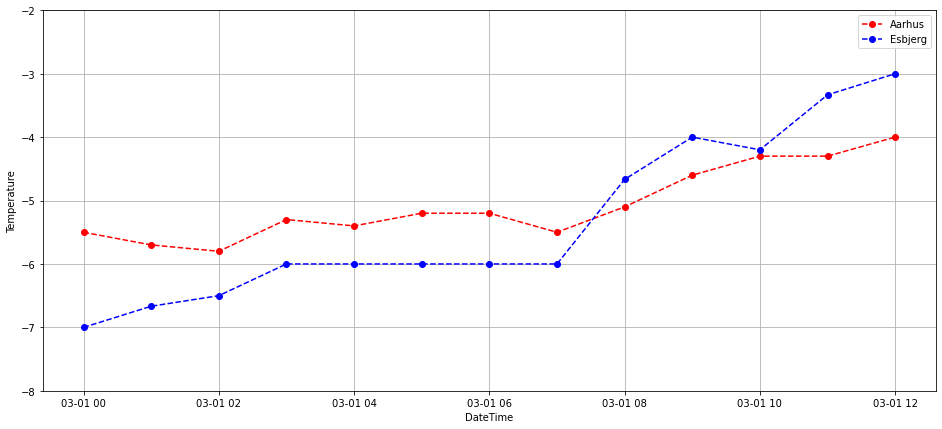

In [5]:
###########################
# Task: 
#   Plot the previous one with the new data
###########################


### TO DO
df_resampled = df_resampled.T.stack().unstack(1) # reshape dataframe to match proper format
city_1 = df_resampled.xs(cities[1])
city_2 = df_resampled.xs(cities[2])

plt.figure(figsize=(16, 7))
plt.plot(city_1.loc['2018-03-01 00:00:00':'2018-03-01 12:00:00', 'Temp'],
         label='Aarhus', linestyle='--', marker='o',  c='r')

plt.plot(city_2.loc['2018-03-01 00:00:00':'2018-03-01 12:00:00', 'Temp'],
         label='Esbjerg', linestyle='--', marker='o',  c='b')

plt.xlabel('DateTime')
plt.ylabel('Temperature')

plt.ylim([-8, -2])
plt.grid()
plt.legend()
plt.show()
#########

## 1.3 - Data overview

We will now analyse the statistical properties of this dataset. Since this dataset is quite big and contains weather data of almost 40 years, in order try to complete the following instructions:
- **_[TO DO]_**  extract the general statistical properties (mean, variance, min value, max value),
- **_[TO DO]_**  for each city, plot the average temperature and the wind speed variance in January for all the years (1980 to 2018) 
- **_[TO DO]_** the maximum temperature and the minimum wind speed in May 

In [6]:
###########################
# Task:
#   extract general statistical properties
#
###########################
### TO DO
def get_city_stats(df):
    stats = pd.DataFrame()
    stats['Mean'] = df.mean()
    stats['Variance'] = df.var()
    stats['Max'] = df.max()
    stats['Min'] = df.min()
    stats = stats.transpose()

    return stats


df_cities = [df.xs(city).reset_index() for city in cities]

df_jan_cities = []


for i, city in enumerate(df_cities):
    df_jan_cities.append(city[city['DateTime'].dt.month == 1])


city_stats = []

for city in df_jan_cities:
    years = []
    for datetime in city['DateTime']:
        year = datetime.year
        if year not in years:
            years.append(year)

    year_temp_data = []
    year_windspeed_data = []

    for year in years:
        year_temp_data.append(
            city.loc[city['DateTime'].dt.year == year]['Temp'].mean())
        year_windspeed_data.append(
            city.loc[city['DateTime'].dt.year == year]['WindSpeed'].var())

    year_df = pd.DataFrame()
    year_df['Year'] = years
    year_df['Avg Temp'] = year_temp_data
    year_df['Windspeed Var'] = year_windspeed_data

    city_stats.append(year_df)





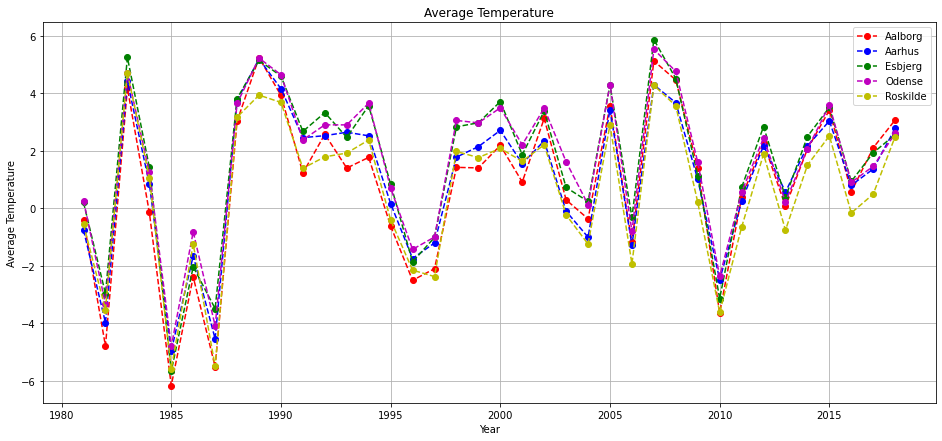

In [7]:
###########################
# Task: 
#   plot average temperature in January from 1980 to 2018.
#
###########################


### TO DO

plt.figure(figsize=(16, 7))
colours = ['r', 'b', 'g', 'm', 'y']
for i, city in enumerate(city_stats):
    plt.plot(city['Year'], city['Avg Temp'],  label=cities[i],
             linestyle='--', marker='o',  c=colours[i])
    plt.xlabel('Year')
    plt.ylabel('Average Temperature')
    plt.legend()
    plt.title('Average Temperature')
    plt.grid()


    

#########

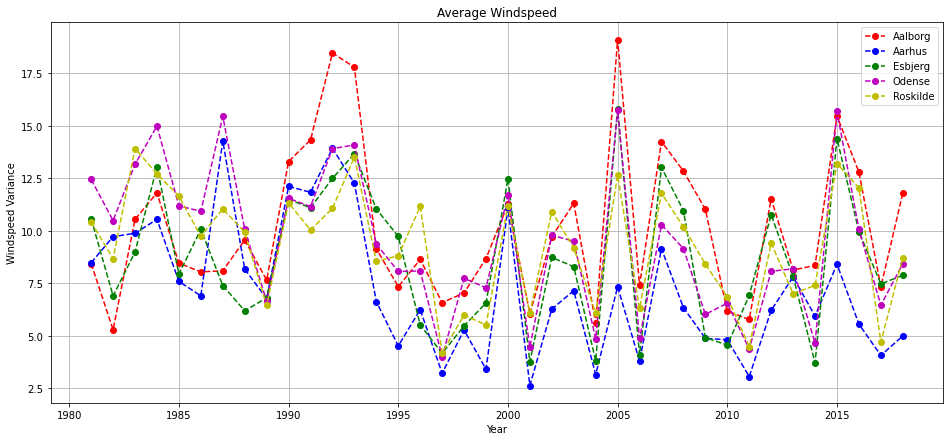

In [8]:
###########################
# Task: 
#   plot average wind speed variance in January from 1980 to 2018.
#
###########################


### TO DO
plt.figure(figsize=(16, 7))
for i, city in enumerate(city_stats):
    plt.plot(city['Year'], city['Windspeed Var'],  label=cities[i],
             linestyle='--', marker='o',  c=colours[i])
    plt.xlabel('Year')
    plt.ylabel('Windspeed Variance')
    plt.legend()
    plt.title('Average Windspeed')
    plt.grid()
#########

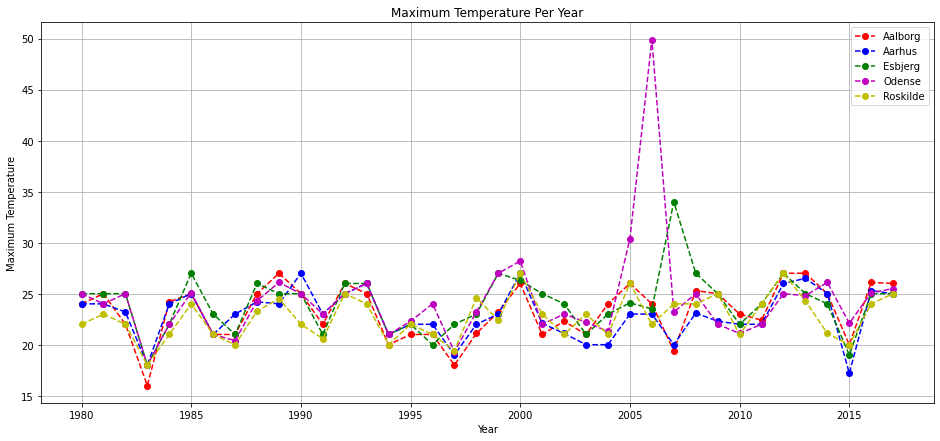

In [15]:
###########################
# Task: 
#   plot maximum temperature in May from 1980 to 2018.
#
###########################


## TO DO

df_may_cities = []
city_stats_may = []

for i, city in enumerate(df_cities):
    df_may_cities.append(city[city['DateTime'].dt.month == 5]) # for may

for city in df_may_cities:
    years = []
    for datetime in city['DateTime']:
        year = datetime.year
        if year not in years:
            years.append(year)

    year_temp_data = []
    year_windspeed_data = []

    for year in years:
        year_temp_data.append(
            city.loc[city['DateTime'].dt.year == year]['Temp'].max())
        year_windspeed_data.append(
            city.loc[city['DateTime'].dt.year == year]['WindSpeed'].min())
        
        

    year_df = pd.DataFrame()
    year_df['Year'] = years
    year_df['Max_Temp'] = year_temp_data
    year_df['Min_Windspeed'] = year_windspeed_data

    city_stats_may.append(year_df)

plt.figure(figsize=(16, 7))
for i, city in enumerate(city_stats_may):
    plt.plot(city['Year'], city['Max_Temp'],  label=cities[i],
             linestyle='--', marker='o',  c=colours[i])
    plt.xlabel('Year')
    plt.ylabel('Maximum Temperature')
    plt.legend()
    plt.title('Maximum Temperature Per Year')
    plt.grid()
    

#########

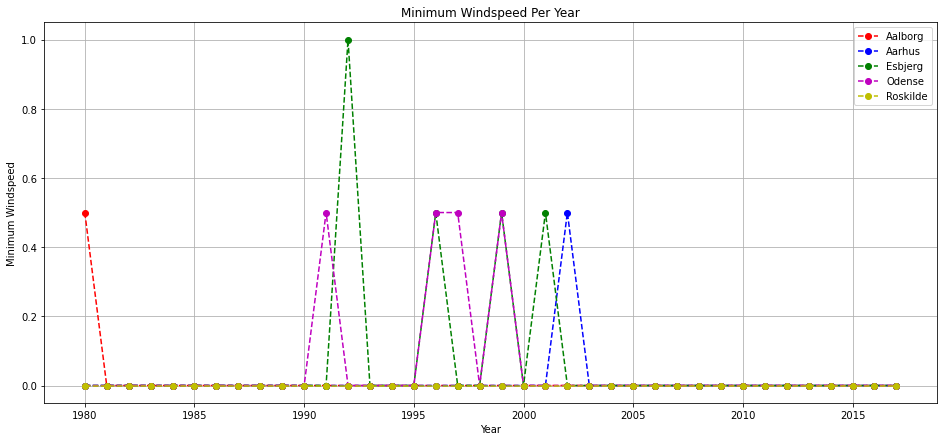

In [17]:
###########################
# Task: 
#   plot minimum wind speed in May from 1980 to 2018.
#
###########################

### TO DO
plt.figure(figsize=(16, 7))
for i, city in enumerate(city_stats_may):
    plt.plot(city['Year'], city['Min_Windspeed'],  label=cities[i],
             linestyle='--', marker='o',  c=colours[i])
    plt.xlabel('Year')
    plt.ylabel('Minimum Windspeed')
    plt.legend()
    plt.title('Minimum Windspeed Per Year')
    plt.grid()


#########

**NOTE:** Look at the scale of the previous plots. Do you think all those zeros actually mean that there was no wind at all?

## 1.4 - Outliers

In the plots you can notice there is definitely an outlier (you could also identify it using the general properties of the dataset as well). 

This is quite a common case one can encounter while dealing with big datasets. Such inconsistancyin the data is likely to affect our inference about the general statistics behind the data. **How to detect such outliers?**


### 1.4.1 Using visualisation tools

The very first method is to spot outliers by using your eyes. For example, open your data and find a
datapoint is clearly different from others. Let's look at different visualisation toos.


#### 1.4.1.1 Box Plot
Boxplots are a standardized way of displaying the distribution of data based on a five number summary (“minimum”, first quartile (Q1), median, third quartile (Q3), and “maximum”):

![](Figures/box_plot.png)

**median (Q2/50th Percentile)**: the middle value of the dataset.

**first quartile (Q1/25th Percentile)**: the middle number between the smallest number (not the “minimum”) and the median of the dataset.

**third quartile (Q3/75th Percentile)**: the middle value between the median and the highest value (not the “maximum”) of the dataset.

**interquartile range (IQR)**: 25th to the 75th percentile.

**“maximum”**: $Q3 + 1.5*IQR$

**“minimum”**: $Q1 -1.5*IQR$

**whiskers** (shown in blue)

**outliers** (shown as green circles)

Back to our max temperature example, let's box-plot and find out the outlier in the data we used to plot "The max temperature in May - city of Odense".

In [ ]:
import seaborn as sns

# extract all the data except the last one because it is a NaN, which is missing value. 
# We will see shortly how to deal with missing value.

outlier_dataset = np.array(may_max_temp_3[:-1])
outlier_year = np.array(year[:-1])

# box plot
sns.boxplot(outlier_dataset)
plt.xlabel(r'Temperature ($^\circ$C)')
plt.xlim([10, 60])
plt.show()

NameError: name 'np' is not defined

As you can see, besides the outlier temperature 50 degrees, there is another outlier temperature around 31 degrees. Is it really an outlier? For 31 degres, it is ambiguous whether it is an outlier or variance.

#### 1.4.1.2 Scatter Plot
A scatter plot is the collection of points that shows values for two variables. 



In [ ]:
# scatter plot: x=year,y=value
plt.scatter(outlier_year,outlier_dataset)
plt.xlabel('Year')
plt.ylabel('Maximum temperature in May - city of Odense')
plt.ylim([15, 55])
plt.grid()
plt.show()

Observe how the data point around 50 degrees seems to clearly deviate from the general case.

### 1.4.2 Using statistics

Statistical methods can also be very useful to detec outliers. Let's look at some examples.

#### 1.4.2.1 Z-score
The Z-score is the signed number of standard deviations, calculated by following equation:

$z=\frac{x-\overline{x}}{S}$

where $\overline{x}$ is the mean value, $S$ is the standard deviation.

Let's see how it works in python.

In [ ]:
from scipy import stats
# calc the abs value of z-score
z = np.abs(stats.zscore(outlier_dataset))

print('z score of the dataset is:\r\n',z)

plt.plot(outlier_year,z)
plt.grid()
plt.ylim([0, 6])
plt.ylabel('Z score')
plt.show()


But, then what? how can we find outlier using these z-scores?

In general, we **put a threshold on z-scores**. Typically, the threshold is 3.
If $|z\_score|>3$, then it is an outlier.

In [ ]:
# set a threshold and find the location where the value meets our condition(s)
threshold = 3
outlier_loc = np.where(z > threshold)

# find the outlier value given its index
outlier_by_Z_Score = outlier_dataset[outlier_loc]
print('the data classified as outlier by z score:\r\n', outlier_by_Z_Score)
print('the year of the outlier is:\r\n', outlier_year[outlier_loc])

#### 1.4.2.2   IQR score
Box plot use the IQR method to display data and outliers(shape of the data) but in order to be get a list of identified outlier, we will need to use the mathematical formula and retrieve the outlier data.

In [ ]:
Q1 = np.quantile(outlier_dataset,0.25)
Q3 = np.quantile(outlier_dataset,0.75)
IQR = Q3-Q1
Minimum = Q1-1.5*IQR
Maximum = Q3+1.5*IQR

# find values that meets the conditions: (outlier_dataset<Minimum) or (outlier_dataset>Maximum)
outlier_by_IQR_Score=outlier_dataset[(outlier_dataset<Minimum) | (outlier_dataset>Maximum)]
print('The data classified as outlier by IQR score:\r\n', outlier_by_IQR_Score)

## 1.4.3 What to do with outliers?

Now that we have ways to detecting outliers, what should we do with them? Let's go through a few potential solutions. 

### 1.4.3.1 Drop them
Simply drop the outliers as long as we have sufficient amount of data left.

Assume we have detected the outlier using z score. We can then drop it easily.

In [ ]:
# find values that meet the conditions: outlier_dataset != outlier_by_Z_Score
# **NOTE** conditions like "array!=value" and  "array==value" only works 
# when value is a single value, not an array. The same mechanism for np.where(array==value).

dropped_outlier_dataset = outlier_dataset[outlier_dataset != outlier_by_Z_Score]

# do the same for year value
dropped_outlier_year = outlier_year[outlier_dataset != outlier_by_Z_Score]

print('Before Drop, the dataset has shape:\r\n', outlier_dataset.shape)
print('After Drop, the dataset has shape:\r\n', dropped_outlier_dataset.shape)

# plot and compare them
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
ax1.set_title('Before Drop')
ax1.scatter(outlier_year,outlier_dataset)
ax1.scatter(outlier_year[outlier_loc], outlier_dataset[outlier_loc], c='r')
ax1.set_ylim([15, 55])
ax1.set_xlabel('Years')
ax1.set_ylabel(r'Temperature ($^\circ$C)')
ax1.grid()

ax2.set_title('After Drop')
ax2.scatter(dropped_outlier_year,dropped_outlier_dataset)
ax2.set_xlabel('Years')
ax2.grid()

plt.show()

### 1.4.3.2 Cap your outliers.
Another way to handle true outliers is to cap them. 

Sometimes, the outlier appears as it hits the upper/lower bound of your sensor. What we can do is to replace it with a setting value, which, for example, could be the max/min value excluding those outliers or just some pre-fixed value.

Let's have a look how to do that in python.

In [ ]:
capped_outlier_dataset=np.copy(outlier_dataset)
print('Before cap the outlier, its value:\r\n',capped_outlier_dataset[outlier_loc])
# cap the outliers
capped_outlier_dataset[outlier_loc]=np.max(dropped_outlier_dataset)
print('After cap the outlier, its value:\r\n',capped_outlier_dataset[outlier_loc])

# plot and compare them
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
ax1.set_title('Before Cap')
ax1.scatter(outlier_year,outlier_dataset)
ax1.scatter(outlier_year[outlier_loc], outlier_dataset[outlier_loc], c='r')
ax1.set_ylim([15, 55])
ax1.set_xlabel('Years')
ax1.set_ylabel(r'Temperature ($^\circ$C)')
ax1.grid()

ax2.set_title('After cap')
ax2.scatter(outlier_year,capped_outlier_dataset)
ax2.scatter(outlier_year[outlier_loc], capped_outlier_dataset[outlier_loc], c='r')
ax2.set_xlabel('Years')
ax2.grid()

plt.show()

### 1.4.3.3 Replace it with a new value.
If an outlier seems to be due to a mistake in your data, you can try imputing another value. Common imputation methods include using the mean of a variable or utilizing a regression model to predict the missing value.

For example, we can replace it with the prediction value by a linear regression model.

Let's have a look how to do that in python.

In [ ]:
replaced_outlier_dataset = np.copy(outlier_dataset)
print('Before replacing, the outlier value is:\r\n',replaced_outlier_dataset[outlier_loc])

# find the coefficient of our linear model using clean data
z = np.polyfit(dropped_outlier_year,dropped_outlier_dataset, deg=1) # deg=1: use 1-order polynomial regression model
# define our linear model
pred_func = np.poly1d(z)
# predict the value of our outlier and replace it
pred_value = pred_func(outlier_year[outlier_loc])
replaced_outlier_dataset[outlier_loc]=pred_value
print('After replacing, the outlier value predicted by a regression model is: \r\n',replaced_outlier_dataset[outlier_loc])

# plot and compare them
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
ax1.set_title('Before replace')
ax1.scatter(outlier_year,outlier_dataset)
ax1.scatter(outlier_year[outlier_loc], outlier_dataset[outlier_loc], c='r')
ax1.set_ylim([15, 55])
ax1.set_xlabel('Years')
ax1.set_ylabel(r'Temperature ($^\circ$C)')
ax1.grid()

ax2.set_title('After replace')
ax2.scatter(outlier_year,replaced_outlier_dataset)
ax2.scatter(outlier_year[outlier_loc], pred_value, c='r')
ax2.set_xlabel('Years')
ax2.grid()

plt.show()

**_[TO DO]_** Congratulations!!! You have learned the techniques needed to detect and deal with outliers. Now, try to detect and deal with outliers in the same dataset showed above, but:

- use the IQR score to detect the outliers
- use the temperature data for the months in which the outliers are found to predict and replace them.
- use a higher order polynomial (2nd or 3rd) to fit the data.

**HINT:** 

1. Find the years that contain outliers, the IQR score might give you different results compared to the z-score
2. Are all the data points detected by the IQR score TRUE outliers?
3. Check the data of the months in which the outliers are found to see if there are more (i.e. the maximum value being an outlier does not necessarily mean it is the only one in that month!)
4. Use the "good" data to fit a 2nd or 3rd order polynomial and estimate the outliers.

In [ ]:
##########
# - use the IQR score to detect the outliers
# - use the temperature data for the months in which the outliers are found to predict and replace them.
# - use a higher order polynomial (2nd or 3rd) to fit the data.

# TO BE COMPLETED 

##########################################################

## 1.5 Missing data

Resampling a dataset does not assure that no missing values will be found afterwards, because the interpolation method incurs in problems when many consecutive NaNs are encountered. In this case, you can see that there are some NaNs in the cities of Esbjerg and Roskilde, but what about the other cities? (remember we were only looking at the head of the dataset, but it actually has more than 330000 rows!)

**_[TO DO]_** count the number of missing values in each column of the dataset.

In [ ]:
# task
#     count the number of missing values in each column of the dataset.

# TO DO
##############################

You can clearly see that the number of missing values is less than 0.5% and only for the pressure in Esbjerg and Roskilde. This does not affect the dataset as a whole, but since it is a time series, it can affect statistics on a yearly (or seasonal) time basis. 

Moreover, a second consideration about the linear interpolation in the resampling step is that the filling process might be deceiving.

**_[TO DO]_** As an example, plot only the signals that in the previous question contained a significant amount of missing values. Can you spot where the linear interpolation does not provide a reliable outcome?

In [ ]:
# TO DO

########################################

**_[TO DO]_** For just one of the two signals, produce a plot of the atmospheric pressure versus time and an histogram distribution for two different years:
- one with mostly "reliable" measurements
- one with an excessive amount of linearly interpolated values

Which differences can you see in those plots?

**HINT:** The typical value of the atmospheric pressure is around 1013 mbar and it has small variance. Therefore the distribution should be a Gaussian.

In [ ]:
# [TO DO (1)] choose one year with many interpolated values, plot it and make an histogram of the distribution
# TO BE COMPLETED

###############################################

In [ ]:
# [TO DO (2)] choose one year with mostly actual observations, plot it and make an histogram of the distribution

# TO BE COMPLETED

### 1.5.1 Imputation of missing data points

Dealing with missing data points (or badly interpolated ones) is not easy. When missing data points are found, there are various approaches that we can consider:

- drop all of them (in this case is quite reasonable as they are only a few, percentage-wise).
- replace with the mean, median or mode. 
- replace with a fixed number, like -1 or 0.

Since we are dealing with a time series, none of these methods seems to be appropriate, especially the replacement. 
Therefore, we could generate this data by creating a predictive model that estimates the missing data from all the other input signals. Then we could fill the gaps by putting these generated values back into the data-set.

This process is also referred to as **imputation**. There are many ways to impute the missing values, one of the most powerful being the *MissForest* module inside the [missingpy](https://pypi.org/project/missingpy/) package (this package is not installed in the base Anaconda environment).

It basically fits a Random Forest (shallow machine learning algorithm) to the data and estimates all the missing values in each column feature. Here we only provide the code to run the MissForest algorithm (which is quite slow on Jupyter!).


As an example, we have pre-trained the MissForest in order to predict the pressure values in Roskilde in 1982 (all the data points are linearly interpolated).

You can see that the imputation consistently replicates how the pressure varies through the year, with a higher variance in winter and a lower one in summer. 

Feel free to install the *missingpy* package (you need to use pip, is not in the Anaconda repository) and try to replace the missing values and the badly interpolated ones.

In [ ]:
df_Esbjerg_imputed = pd.read_pickle('./weather-data/weather_Esbjerg_imputed.pkl')

In [ ]:
plt.figure(figsize=(16, 7))
df_resampled['Esbjerg'].loc['1980-03-01 10:00:00':'1995-12-31 23:00:00','Pressure'].plot()
df_Esbjerg_imputed.loc['1982-01-01 00:00:00':'1982-12-31 23:00:00','Pressure'].plot(alpha=0.7)

plt.ylim([960, 1060])
plt.ylabel('Pressure (mbar)')
plt.show()